In [ ]:
import jax.numpy as jnp
import jax
import numpyro
import numpyro.distributions as dist
from abm.spatial_compartmental.si import get_abm as get_si_abm
from abm.spatial_compartmental.sir import get_abm as get_sir_abm
from abm.spatial_compartmental.utils import Neighbourhood


/home/tim/Documents/thesis/dgs4abm/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DIAG COV SI

In [2]:
si_abm = get_si_abm(Neighbourhood.DIAGONAL, vmap=True)    

In [3]:
def p_infect_prior():
    p_infect = numpyro.sample("p_infect", dist.Beta(2, 5))
    return p_infect
def diag_cov_ABM_model(
    abm, n_sims, grid_size, num_steps, n_initial_infected, data=None
):
    p_infect = p_infect_prior()
    _, _, I_t = abm(
        jax.random.split(numpyro.prng_key(), n_sims),
        grid_size,
        num_steps,
        p_infect,
        n_initial_infected,
    )
    with numpyro.plate('N',10):
        I_t=numpyro.deterministic("realisation",I_t)
    # NOTE: Since the first count is always the same, we exclude it from the likelihood
    sample_mean = numpyro.deterministic("sample_mean",jnp.mean(I_t[:, 1:], axis=0))
    sample_std = numpyro.deterministic("sample_std",jnp.std(I_t[:, 1:], axis=0, ddof=1) + 1e-7)
    with numpyro.plate('M',len(data)):
        numpyro.sample("obs", dist.Normal(sample_mean, sample_std), obs=data)

In [10]:
graph=numpyro.render_model(diag_cov_ABM_model, model_args=(si_abm, 50, 10, 10, 20,jnp.zeros(10)), render_params=False, render_distributions=False)

In [11]:
# 3. Find the 'I_t' node and modify its shape to 'circle'
target_label = 'label=realisation'
new_body = []
for line in graph.body:
    #print(line)
    if target_label in line:
        print(f"Original line: {line}")
        # --- This is the only change required ---
        modified_line = line.replace('style="filled,dashed"', 'style=filled')
        new_body.append(modified_line)
        print(f"Modified line: {modified_line}")
    # elif 'distribution_description_node' in line:
    #     modified_line = line.replace('realisation ~ Deterministic', 'realisation ~ SI ABM / Surrogate')
    #     new_body.append(modified_line)
    else:
        new_body.append(line)
# 4. Overwrite the graph's body with our modified version
graph.body = new_body

graph.body.append(
    '"n_initial_infected" [label="n_initial_infected", shape="plain"]'
)

# 4. Step 2: Add the edge connecting it to the simulation
# This draws an arrow from our new node to the "realisation" node.
graph.body.append(
    '"n_initial_infected" -> "realisation"'
)



Original line: 		realisation [label=realisation fillcolor=white shape=ellipse style="filled,dashed"]

Modified line: 		realisation [label=realisation fillcolor=white shape=ellipse style=filled]



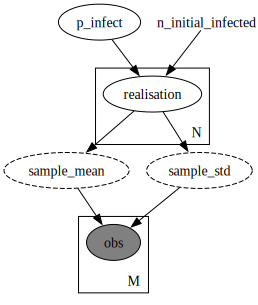

In [12]:
graph

In [13]:
graph.render(
    "si_numpyro_model",  # The output filename (without extension)
    format="pdf",      # Specify the format: 'png', 'pdf', 'svg', etc.
    view=False,        # Set to False so it doesn't try to open the file
    cleanup=True       # Set to True to delete the source '.gv' file after rendering
)

'si_numpyro_model.pdf'

# FULL COV SIR

In [2]:
sir_abm = get_sir_abm(Neighbourhood.VONNEUMANN, vmap=True)    

In [5]:

def vectorized_abm_state_counts(abm_grids_batch):
    """
    Calculates state counts for a batch of ABM grids using JAX.

    Args:
        abm_grids_batch (jnp.ndarray): An array of shape (batch_size, steps, 3, H, W)
                                       representing all grids at a single time step.

    Returns:
        dict: A dictionary where keys are state names (str) and values are
              JAX arrays (shape (batch_size,)) containing the counts of that
              state for each grid in the batch.
    """
    counts = {}
    # Susceptible: (layer0==0) & (layer1==1) & (layer2==0)
    counts["Susceptible"] = jnp.sum(
        (abm_grids_batch[:, :, 0, :, :] == 0)
        & (abm_grids_batch[:, :, 1, :, :] == 1)
        & (abm_grids_batch[:, :, 2, :, :] == 0),
        axis=(2, 3),
    ).astype(jnp.int32)

    # Infected: (layer0==1) & (layer1==0) & (layer2==0)
    counts["Infected"] = jnp.sum(
        (abm_grids_batch[:, :, 0, :, :] == 1)
        & (abm_grids_batch[:, :, 1, :, :] == 0)
        & (abm_grids_batch[:, :, 2, :, :] == 0),
        axis=(2, 3),
    ).astype(jnp.int32)

    # Recovered: (layer0==0) & (layer1==0) & (layer2==1)
    counts["Recovered"] = jnp.sum(
        (abm_grids_batch[:, :, 0, :, :] == 0)
        & (abm_grids_batch[:, :, 1, :, :] == 0)
        & (abm_grids_batch[:, :, 2, :, :] == 1),
        axis=(2, 3),
    ).astype(jnp.int32)
    return counts


def full_cov_no_move_sir_ABM_model(
    abm,
    n_sims,
    grid_size,
    num_steps,
    total_population,
    n_initial_infected,
    n_initial_recovered,
    data=None,
):
    p_infect = numpyro.sample("p_infect", dist.Beta(2, 5))
    p_recover = numpyro.sample("p_recover", dist.Beta(2, 5)) 
    p_wane = numpyro.sample("p_wane", dist.Beta(2, 5))

    multi_grid_timeseries = abm(
        jax.random.split(numpyro.prng_key(), n_sims),
        grid_size,
        num_steps,
        p_infect,
        p_recover,
        p_wane,
        0.0,  # No Movement
        total_population,
        n_initial_infected,
        n_initial_recovered,
    )

    state_count_timeseries = vectorized_abm_state_counts(multi_grid_timeseries)
    with numpyro.plate('N',10):
        state_count_timeseries=numpyro.deterministic("realisation",state_count_timeseries)

    means = {k: jnp.mean(x[:, 1:], axis=0) for k, x in state_count_timeseries.items()}

    stacked = jnp.concatenate(
        [x[:, 1:] for x in list(state_count_timeseries.values())[1:]], axis=1
    )
    mean = numpyro.deterministic("sample_mean",jnp.concatenate((means["Infected"], means["Recovered"])))
    covariance = numpyro.deterministic("sample_covariance",jnp.cov(stacked, rowvar=False) + 1e-7 * jnp.eye(mean.shape[0]))
    numpyro.sample("obs", dist.MultivariateNormal(mean, covariance), obs=data)


In [18]:
graph=numpyro.render_model(full_cov_no_move_sir_ABM_model, model_args=(sir_abm, 50, 10, 10, 20, 2,5, jnp.zeros(20)), render_params=False, render_distributions=False)

In [19]:
# 3. Find the 'I_t' node and modify its shape to 'circle'
target_label = 'label=realisation'
new_body = []
for line in graph.body:
    #print(line)
    if target_label in line:
        print(f"Original line: {line}")
        # --- This is the only change required ---
        modified_line = line.replace('style="filled,dashed"', 'style=filled')
        new_body.append(modified_line)
        print(f"Modified line: {modified_line}")
    # elif 'distribution_description_node' in line:
    #     modified_line = line.replace('realisation ~ Deterministic', 'realisation ~ SI ABM / Surrogate')
    #     new_body.append(modified_line)
    else:
        new_body.append(line)
# 4. Overwrite the graph's body with our modified version
graph.body = new_body

graph.body.append(
    '"total_population" [label="total_population", shape="plain"]'
)
graph.body.append(
    '"n_initial_infected" [label="n_initial_infected", shape="plain"]'
)
graph.body.append(
    '"n_initial_recovered" [label="n_initial_recovered", shape="plain"]'
)

# 4. Step 2: Add the edge connecting it to the simulation
# This draws an arrow from our new node to the "realisation" node.
graph.body.append(
    '"total_population" -> "realisation"'
)

graph.body.append(
    '"n_initial_infected" -> "realisation"'
)
graph.body.append(
    '"n_initial_recovered" -> "realisation"'
)

graph.body.append(
    '"p_infect" -> "realisation"'
)

graph.body.append(
    '"p_recover" -> "realisation"'
)
graph.body.append(
    '"p_wane" -> "realisation"'
)



Original line: 		realisation [label=realisation fillcolor=white shape=ellipse style="filled,dashed"]

Modified line: 		realisation [label=realisation fillcolor=white shape=ellipse style=filled]



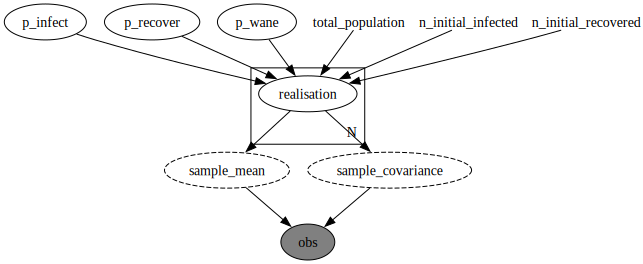

In [20]:
graph

In [ ]:
graph.render(
    "full_cov_sir_numpyro_model",  # The output filename (without extension)
    format="pdf",      # Specify the format: 'png', 'pdf', 'svg', etc.
    view=False,        # Set to False so it doesn't try to open the file
    cleanup=True       # Set to True to delete the source '.gv' file after rendering
)